# WhatsApp analysis

This notebook can be used as a starting point for your group chat text analsys. Group chat can be dowloaded through WhatsApp application in __group chat settings__ - __export chat__ - __without media__ (if you plan to deal with only text part of the chat).

## Data reading

In [18]:
import re
import pandas as pd

def extract_msg(line):
    "Regex to extract datetime, sender and message."
    date = []
    msg = []
    sender_name = []
    # As for 27/10/2018 the default WhatsApp date format is as follows.
    datetime_pat  = "\d\d/\d\d\/\d\d\d\d,\ \d\d\:\d\d" 
    
    # If not date was found then treat line as continuation of the previous message.
    date = re.search(datetime_pat, line)
    if date is None:
        return None, None, line
    
    sender_pat = "\-\ .*?[^:]+:"
    sender = re.search(sender_pat, line)
    
    # Assumes a name and last name is less than at most 25 chars. 
    # Avoids misclassifying a status change with a semi-colon for a name.
    if sender is None or len(sender.group(0)) > 25:
        return None, None, None

    date = pd.to_datetime(date.group(0))        
    sender_name = sender.group(0)[2:-1]

    msg = line[line.index(sender_name)+len(sender_name)+2:]
        
    return date, sender_name, msg

# Parse the entire conversation as a pd.dataframe.

# Name of the file relative to current IPython notebook.
path_to_file = './sampleGroupTest.txt' 
f = open(path_to_file, 'r', encoding='utf-8')

# Create DataFrame for data.
conv = pd.DataFrame(columns=['date','sender','message'])

line = f.readline()
date, sender, msg = extract_msg(line)

# If conversation file starts with status change, which is not message.
while date is None and line != '':
    line = f.readline()
    date, sender, msg = extract_msg(line)

for line in f:
    dateTemp, senderTemp, msgTemp  = extract_msg(line)
    # If current line is status change.
    if msgTemp is None:
        continue
    # If current line is continuation of previous line.
    if dateTemp is None:
        msg += msgTemp
        continue
    # Save previous message in dataframe.
    temp_df = pd.Series({'date':date ,'sender':sender,'message':msg})
    conv = conv.append(temp_df, ignore_index=True)
    date = dateTemp
    sender = senderTemp
    msg = msgTemp

# If last line(s) is not status changes.
if date is not None and msg is not None:
    temp_df = pd.Series({'date':date ,'sender':sender,'message':msg})
    conv = conv.append(temp_df, ignore_index=True)
    
f.close()

## Default imports for text processing and plotting

In [19]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import wordcloud
from wordcloud import WordCloud

## Data preprocessing and analysis

In [20]:
conv.describe().T

,count,unique,top,freq,first,last
date,9402,3431,2018-10-02 03:23:00,26,2017-01-04 23:31:00,2018-12-03 22:13:00
sender,9402,6,Person1,2769,NaN,NaN
message,9402,6781,<Media omitted>\n,1092,NaN,NaN


In [21]:
conv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9402 entries, 0 to 9401
Data columns (total 3 columns):
date       9402 non-null datetime64[ns]
sender     9402 non-null object
message    9402 non-null object
dtypes: datetime64[ns](1), object(2)
memory usage: 220.4+ KB


Remove or edit sender column

In [22]:
conv.sender.unique()

array(['Person1', '\u202aPerson3', 'Person2', 'Person4', 'Person5',
       'Person3'], dtype=object)

Removal of left-to-right embedding

In [23]:
conv.sender = conv.sender.map(lambda s: str(s.encode('ascii',errors='ignore')))
conv.sender.unique()

array(["b'Person1'", "b'Person3'", "b'Person2'", "b'Person4'",
       "b'Person5'"], dtype=object)

In [24]:
conv['media'] = conv.message.str.count('Media omitted')

*******

### Little reminder on MultiIndex

In [25]:
arrays = [np.array(['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux']),
          np.array(['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']),
          np.array(['1', '1', '1', '1', '2', '2', '2', '2'])]

index = pd.MultiIndex.from_arrays(arrays)

temp = pd.DataFrame(data=np.round(np.random.rand(8,8), 3),
                    index=index, columns=index
                    )
temp

bar           baz           foo           qux       
             one    two    one    two    one    two    one    two
               1      1      1      1      2      2      2      2
bar one 1  0.823  0.666  0.979  0.181  0.697  0.935  0.753  0.782
    two 1  0.754  0.745  0.438  0.770  0.980  0.398  0.334  0.919
baz one 1  0.554  0.168  0.974  0.851  0.087  0.059  0.816  0.567
    two 1  0.116  0.989  0.834  0.659  0.376  0.622  0.962  0.385
foo one 2  0.199  0.976  0.310  0.002  0.506  0.937  0.510  0.402
    two 2  0.679  0.383  0.210  0.882  0.953  0.786  0.658  0.279
qux one 2  0.272  0.489  0.735  0.133  0.187  0.510  0.169  0.895
    two 2  0.443  0.541  0.972  0.153  0.678  0.367  0.451  0.673

In [26]:
idx = pd.IndexSlice
temp.loc[idx['bar':'baz', :, '1'],idx['foo':'qux','two',:]]

foo    qux
             two    two
               2      2
bar one 1  0.935  0.782
    two 1  0.398  0.919
baz one 1  0.059  0.567
    two 1  0.622  0.385

In [27]:
temp.unstack() # unstack the last level of Index

bar                         baz                         foo         \
           one           two           one           two           one          
             1             1             1             1             2          
             1      2      1      2      1      2      1      2      1      2   
bar one  0.823    NaN  0.666    NaN  0.979    NaN  0.181    NaN  0.697    NaN   
    two  0.754    NaN  0.745    NaN  0.438    NaN  0.770    NaN  0.980    NaN   
baz one  0.554    NaN  0.168    NaN  0.974    NaN  0.851    NaN  0.087    NaN   
    two  0.116    NaN  0.989    NaN  0.834    NaN  0.659    NaN  0.376    NaN   
foo one    NaN  0.199    NaN  0.976    NaN  0.310    NaN  0.002    NaN  0.506   
    two    NaN  0.679    NaN  0.383    NaN  0.210    NaN  0.882    NaN  0.953   
qux one    NaN  0.272    NaN  0.489    NaN  0.735    NaN  0.133    NaN  0.187   
    two    NaN  0.443    NaN  0.541    NaN  0.972    NaN  0.153    NaN  0.678   

                         qux                       
           two           one           two         
             2             2             2         
             1      2      1      2      1      2  
bar one  0.935    NaN  0.753    NaN  0.782    NaN  
    two  0.398    NaN  0.334    NaN  0.919    NaN  
baz one  0.059    NaN  0.816    NaN  0.567    NaN  
    two  0.622    NaN  0.962    NaN  0.385    NaN  
foo one    NaN  0.937    NaN  0.510    NaN  0.402  
    two    NaN  0.786    NaN  0.658    NaN  0.279  
qux one    NaN  0.510    NaN  0.169    NaN  0.895  
    two    NaN  0.367    NaN  0.451    NaN  0.673

In [28]:
temp.unstack(level=0) # unstack the first level of Index

bar                                                     baz         \
         one                         two                         one          
           1                           1                           1          
         bar    baz    foo    qux    bar    baz    foo    qux    bar    baz   
one 1  0.823  0.554    NaN    NaN  0.666  0.168    NaN    NaN  0.979  0.974   
    2    NaN    NaN  0.199  0.272    NaN    NaN  0.976  0.489    NaN    NaN   
two 1  0.754  0.116    NaN    NaN  0.745  0.989    NaN    NaN  0.438  0.834   
    2    NaN    NaN  0.679  0.443    NaN    NaN  0.383  0.541    NaN    NaN   

       ...      foo           qux                                            \
       ...      two           one                         two                 
       ...        2             2                           2                 
       ...      foo    qux    bar    baz    foo    qux    bar    baz    foo   
one 1  ...      NaN    NaN  0.753  0.816    NaN    NaN  0.782  0.567    NaN   
    2  ...    0.937  0.510    NaN    NaN  0.510  0.169    NaN    NaN  0.402   
two 1  ...      NaN    NaN  0.334  0.962    NaN    NaN  0.919  0.385    NaN   
    2  ...    0.786  0.367    NaN    NaN  0.658  0.451    NaN    NaN  0.279   

              
              
              
         qux  
one 1    NaN  
    2  0.895  
two 1    NaN  
    2  0.673  

[4 rows x 32 columns]

In [29]:
temp.unstack([1,2]) # unstack 1st and 2nd level of Index

bar                                                     baz         \
       one                         two                         one          
         1                           1                           1          
       one           two           one           two           one          
         1      2      1      2      1      2      1      2      1      2   
bar  0.823    NaN  0.754    NaN  0.666    NaN  0.745    NaN  0.979    NaN   
baz  0.554    NaN  0.116    NaN  0.168    NaN  0.989    NaN  0.974    NaN   
foo    NaN  0.199    NaN  0.679    NaN  0.976    NaN  0.383    NaN  0.310   
qux    NaN  0.272    NaN  0.443    NaN  0.489    NaN  0.541    NaN  0.735   

     ...      foo           qux                                            \
     ...      two           one                         two                 
     ...        2             2                           2                 
     ...      two           one           two           one           two   
     ...        1      2      1      2      1      2      1      2      1   
bar  ...    0.398    NaN  0.753    NaN  0.334    NaN  0.782    NaN  0.919   
baz  ...    0.622    NaN  0.816    NaN  0.962    NaN  0.567    NaN  0.385   
foo  ...      NaN  0.786    NaN  0.510    NaN  0.658    NaN  0.402    NaN   
qux  ...      NaN  0.367    NaN  0.169    NaN  0.451    NaN  0.895    NaN   

            
            
            
            
         2  
bar    NaN  
baz    NaN  
foo  0.279  
qux  0.673  

[4 rows x 32 columns]

***

Why bother studying MultiIndexing? It is very useful for plotting DataFrame when used with GroupBy

In [40]:
temp=conv.groupby(['date', 'sender','media'])['message'].count()
temp=temp.unstack(['sender', 'media']).resample('1m').sum()
temp = temp.loc[:, temp.columns.get_level_values('media')==1]
temp.head()

sender,b'Person4',b'Person1',b'Person2',b'Person3',b'Person5'
media,1,1,1,1,1
date,,,,,
2017-01-31,17.0,12.0,8.0,10.0,14.0
2017-02-28,6.0,4.0,7.0,0.0,18.0
2017-03-31,19.0,9.0,6.0,2.0,4.0
2017-04-30,10.0,5.0,1.0,0.0,4.0
2017-05-31,5.0,1.0,1.0,6.0,7.0


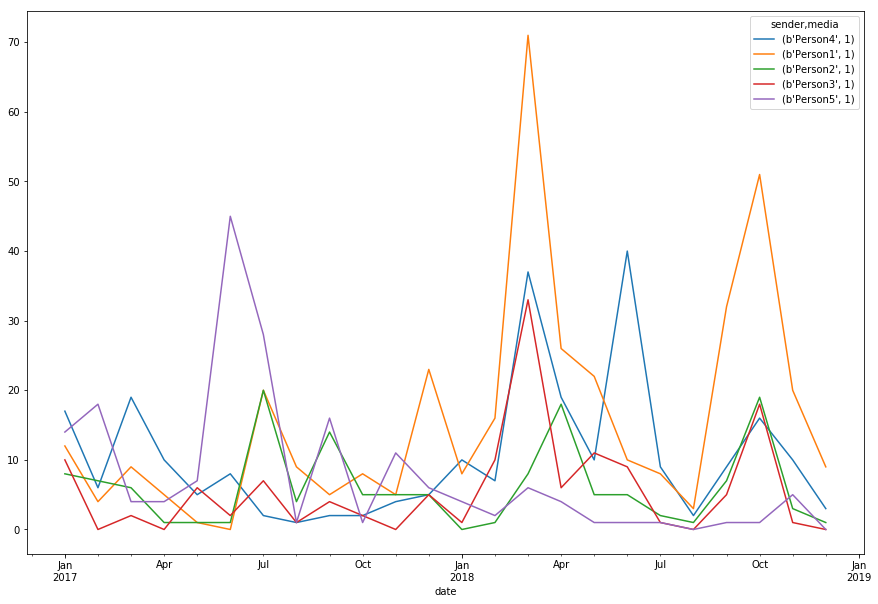

In [41]:
temp.plot(figsize=(15,10));

In [42]:
temp = conv.groupby([conv.date.dt.weekday])['message'].size().to_frame()
temp.index.name=None
temp.rename({0:'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thur', 4: 'Fri', 5: 'Sun', 6: 'Sat'}, inplace=True)
temp.rename_axis('weekday')

,message
weekday,
Mon,1078
Tue,1895
Wed,1105
Thur,843
Fri,1492
Sun,1820
Sat,1169


***

### Some visualization with time series

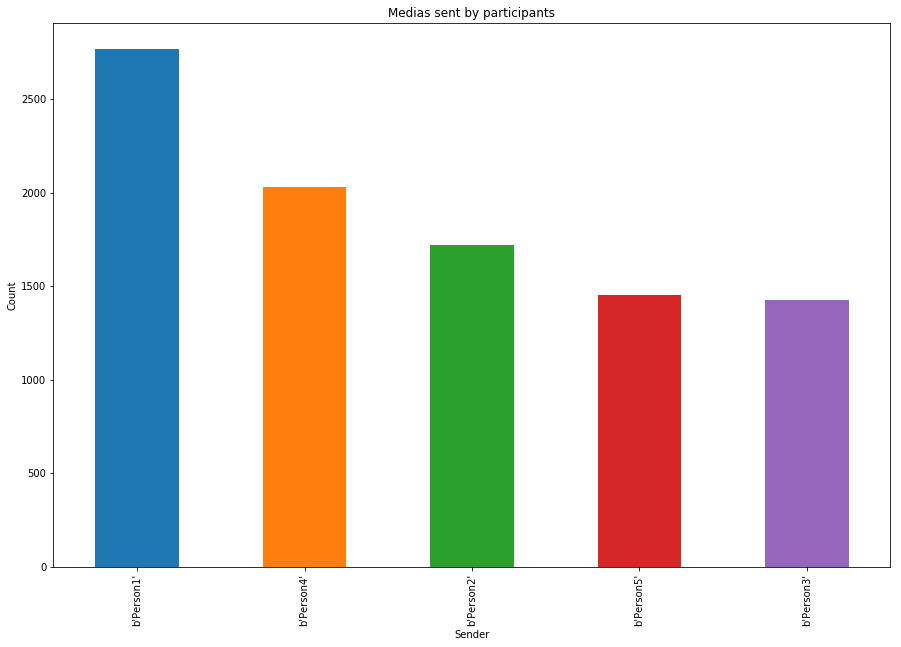

In [43]:
ax = conv.groupby('sender')['media'].agg('count').rename('count').sort_values(ascending=False)\
.plot.bar(figsize=(15,10))
ax.set_title('Medias sent by participants')
ax.set_xlabel('Sender')
ax.set_ylabel('Count');

In [44]:
temp = conv.groupby(['date','sender'])['message'].count().rename('count')

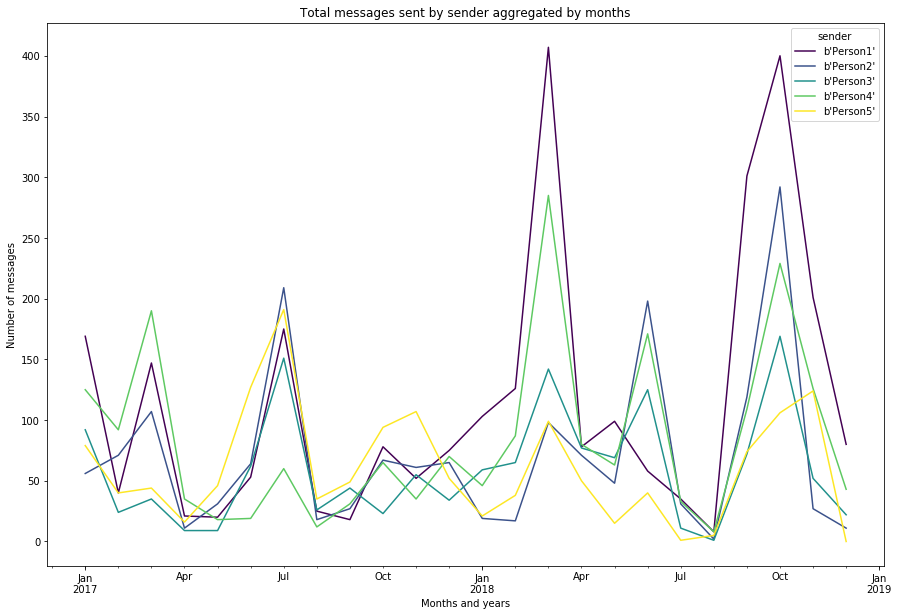

In [45]:
ax = temp.unstack(level='sender').resample('1m').sum() \
.plot(figsize=(15,10), colormap='viridis')

ax.set_title('Total messages sent by sender aggregated by months')
ax.set_ylabel('Number of messages')
ax.set_xlabel('Months and years');

In [46]:
d = dict(zip(np.sort(conv.sender.unique()),['Fox', 'Zebra', 'Panda', 'Wolf', 'Bear']))

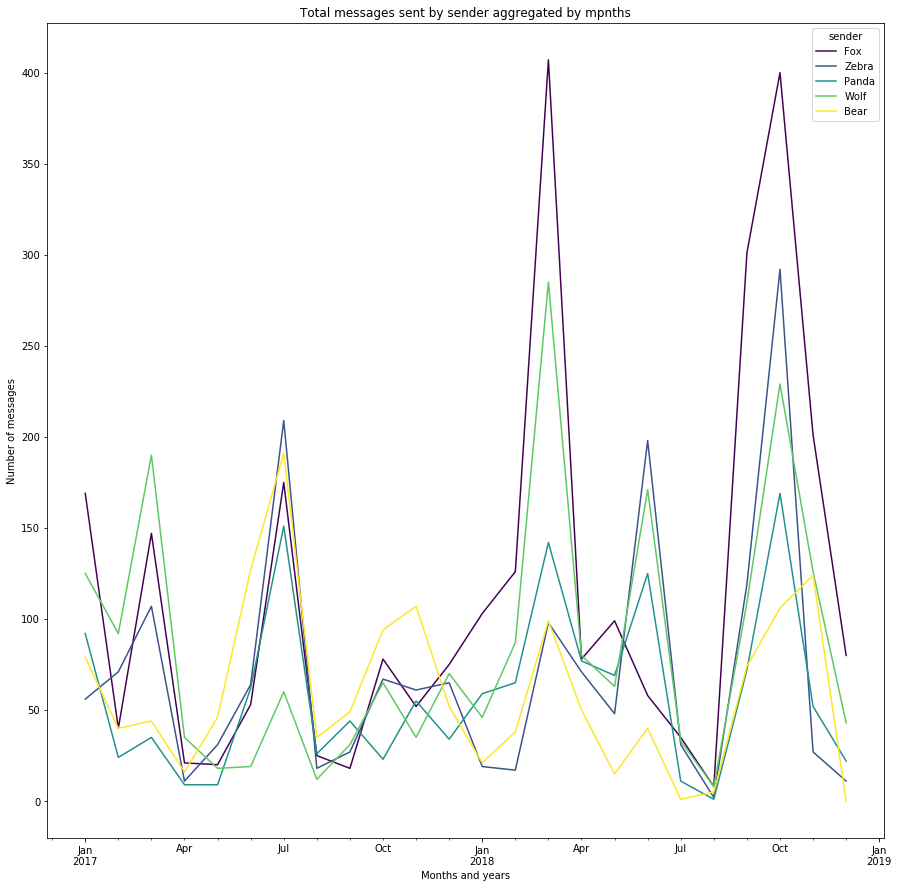

In [47]:
temp = conv.groupby(['date','sender'])['message'].count().rename('count').unstack('sender')
ax = temp.rename(d, axis=1).resample('m').sum() \
.plot(figsize=(15,15), colormap='viridis')

ax.set_title('Total messages sent by sender aggregated by mpnths')
ax.set_ylabel('Number of messages')
ax.set_xlabel('Months and years')
plt.savefig('FrequencyOfMessages')

### Text preprocessing, cleaning, and analysis

In [48]:
# remove media messages
conv['message'] = conv.message.apply(str.strip)
conv.loc[conv.message.str.contains('Media'),'message'] = ''
conv.head()

,date,sender,message,media
0,2017-01-13 18:32:00,b'Person1',,1
1,2017-01-13 18:34:00,b'Person3',😂😂,0
2,2017-01-13 18:35:00,b'Person3',Сзади чуваки подумали наверное что типо ты ким...,0
3,2017-01-13 18:35:00,b'Person3',Ты мне звонил да? Я не успела и на работе была),0
4,2017-01-13 18:36:00,b'Person3',Куда направляешься?,0


In [49]:
def preProcess(text):
    
    # lowercase
    text=text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W|_)+"," ",text)
    
    return text
 
conv['clean'] = conv['message'].apply(lambda x: preProcess(x))

conv[['message', 'clean']].head()

,message,clean
0,,
1,😂😂,
2,Сзади чуваки подумали наверное что типо ты ким...,сзади чуваки подумали наверное что типо ты ким...
3,Ты мне звонил да? Я не успела и на работе была),ты мне звонил да я не успела и на работе была
4,Куда направляешься?,куда направляешься


In [50]:
conv[conv['clean'].apply(str.strip).apply(len)==0].head()

,date,sender,message,media,clean
0,2017-01-13 18:32:00,b'Person1',,1,
1,2017-01-13 18:34:00,b'Person3',😂😂,0,
6,2017-01-13 18:39:00,b'Person2',,1,
7,2017-01-13 18:43:00,b'Person1',,1,
15,2017-01-13 19:49:00,b'Person2',,1,


In [51]:
d

{"b'Person1'": 'Fox',
 "b'Person2'": 'Zebra',
 "b'Person3'": 'Panda',
 "b'Person4'": 'Wolf',
 "b'Person5'": 'Bear'}

In [52]:
def get_stop_words(stop_file_path):
    """load stop words """
    
    with open(stop_file_path, 'r', encoding="utf-8") as f:
        stopwords = f.readlines()
        stop_set = set(m.strip() for m in stopwords)
        return frozenset(stop_set)
 
#load a set of stop words
stopwords=get_stop_words("./stop-words-russian.txt")
 
#get the text column 
docs=conv.loc[conv.sender==list(d.keys())[3], 'clean'].tolist()

#create a vocabulary of words, 
#eliminate stop words

vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=0.001, max_features=100)
X = vectorizer.fit_transform(docs)

In [53]:
# http://stackoverflow.com/questions/16078015/
scores = zip(vectorizer.get_feature_names(),
             np.asarray(X.sum(axis=0)).ravel())
sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

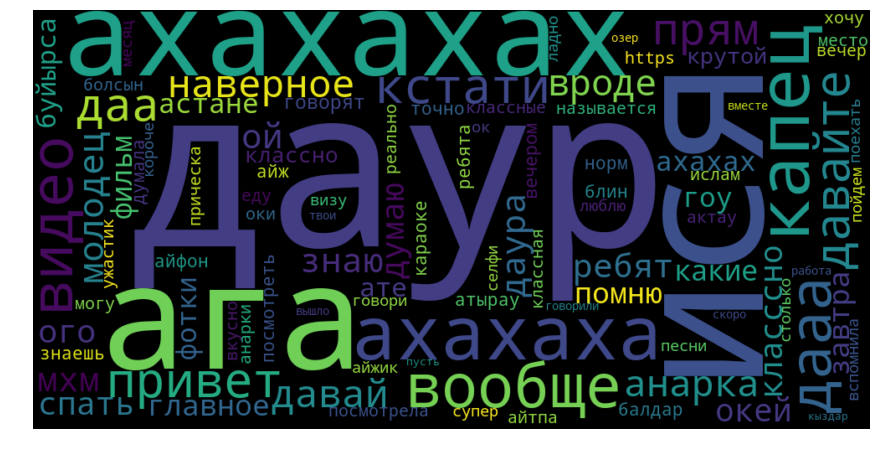

In [54]:
import wordcloud
from wordcloud import WordCloud
%matplotlib inline

# Generate a word cloud image
wordcloud = WordCloud(width=1000, height=500).fit_words(dict(sorted_scores))

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wolf_wc')

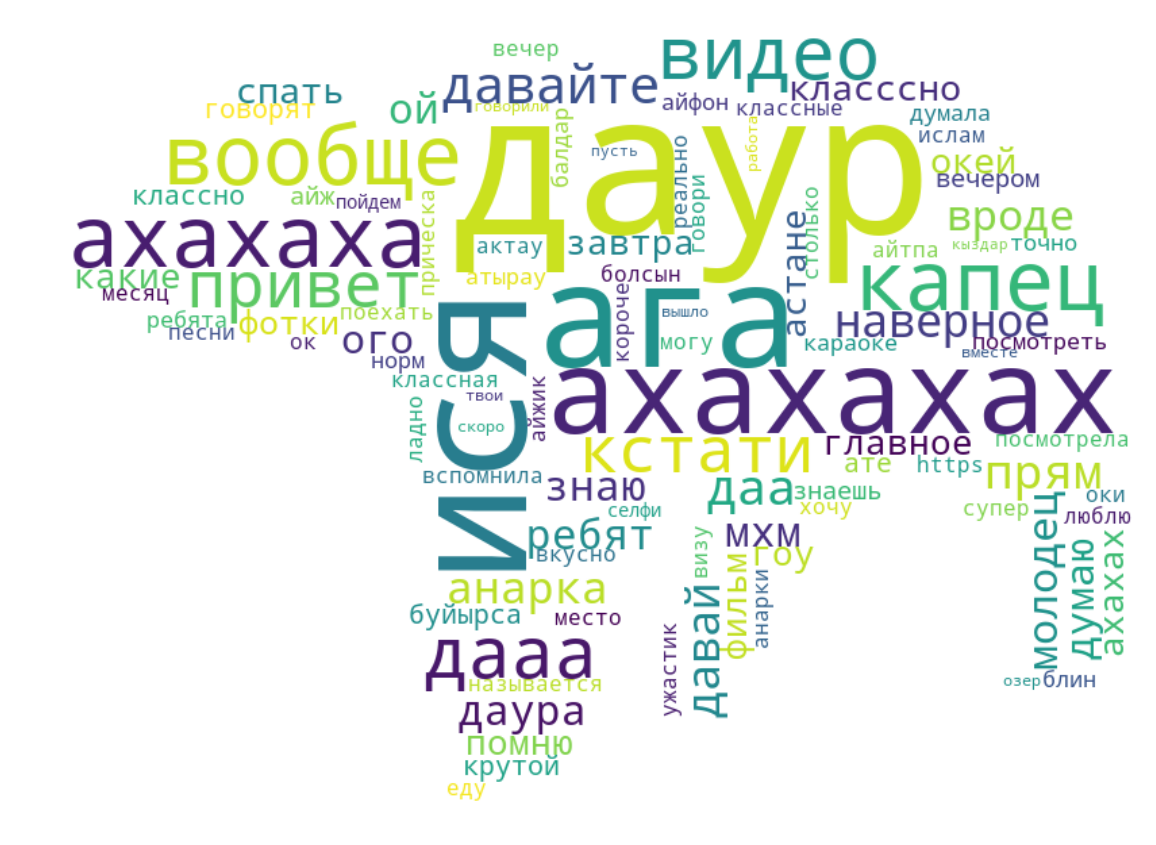

In [56]:
from PIL import Image

from wordcloud import WordCloud, STOPWORDS


mask = (np.array(Image.open("bear.jpg")))


wc = WordCloud(background_color='white', mask=mask)
wc.fit_words(dict(sorted_scores))


# show
plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('bear_fig')

# Total messages sent :

In [57]:
print("We have sent a total of %d Messages since %s" % (len(conv), conv.date.min()))

We have sent a total of 9402 Messages since 2017-01-04 23:31:00


# Total number of messages sent per person

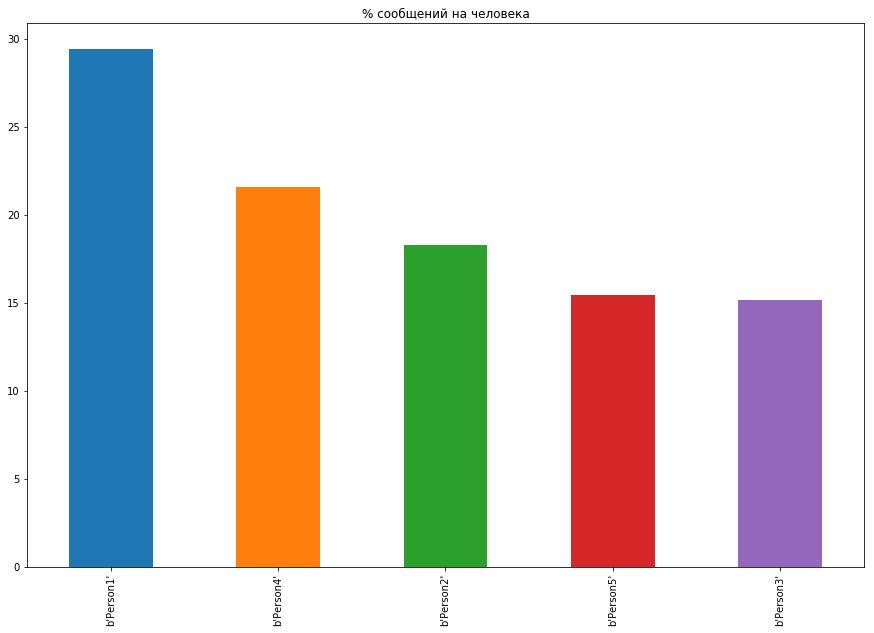

In [58]:
# Messages per harman

counts = conv['sender'].value_counts()/len(conv)*100

%matplotlib inline
fig = counts.plot("bar", title="% сообщений на человека", figsize=(15,10))
plt.savefig("Percent of messages")

# Interactions

Interpret this next graph as "This person has answered directly to this person this many times". For example, Alice and Bob answer each other most often. For "equal" dialogue, the matrix should be symmetric along its diagonal. Interactions with oneself are ignored.

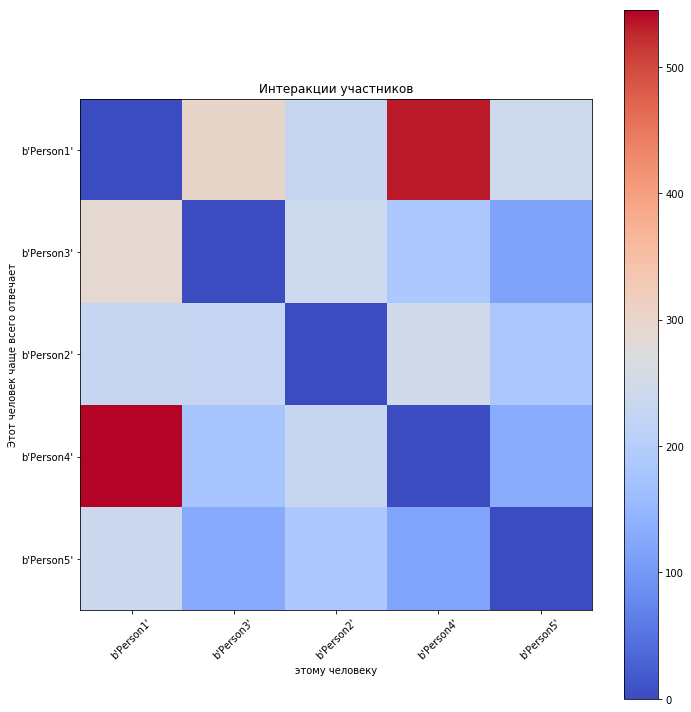

In [60]:
index = {}
names = []

for count,sender in enumerate(conv['sender'].unique()):
    index[sender] = count
    names.append(sender)


interactions = np.zeros((len(index),len(index)))

prev_sender = conv['sender'].iloc[0]
for jj in range(1,len(conv)):
    
    current_sender = conv['sender'].iloc[jj]
    if prev_sender != current_sender:
        interactions[index[prev_sender],index[current_sender]]+=1
    
    prev_sender = current_sender

def plot_interactions(cm, classes,
                      normalize=False,
                      title='Интеракции участников',
                      cmap=plt.cm.coolwarm):

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'f'
    thresh = cm.max() / 2.

    plt.tight_layout()
    plt.ylabel('Этот человек чаще всего отвечает')
    plt.xlabel('этому человеку')

plot_interactions(interactions,names)
plt.savefig("Interactions")

# The longest monologue

In [62]:
prev_sender = []
max_spam = 0
tmp_spam = 0

for jj in range(len(conv)):
    
    current_sender = conv['sender'].iloc[jj]
    if current_sender == prev_sender:
        tmp_spam += 1
        if tmp_spam>max_spam:
            max_spam = tmp_spam
            max_spammer = current_sender
    else:
        tmp_spam = 0
    
    prev_sender = current_sender
        
print("Самый длинный монолог от %s с %d последующими сообщениями" % (max_spammer,max_spam))


Самый длинный монолог от b'Person5' с 28 последующими сообщениями
